# Tatoeba: N-Gram Hashing

Author: Pierre Nugues

In this notbook, we will reduce the size of the n-gram vectors using hashing techniques

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [1]:
import random
from collections import Counter
import torch
import matplotlib.pyplot as plt

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [3]:
FILE = 'train.tsv'

In [4]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'

In [5]:
SMALL = False

In [6]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
else:
    dataset_path = LARGE_DATASET_PATH
    
WORKING_FILE = dataset_path + '/' + FILE

We create a generator

In [7]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [8]:
line_generator = file_reader(WORKING_FILE)

And we count the sentences per language

In [9]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [10]:
lang_freqs.most_common(15)

[('rus', 12314),
 ('mkd', 12149),
 ('lfn', 12132),
 ('srp', 12127),
 ('lit', 12126),
 ('lat', 12115),
 ('bul', 12111),
 ('ukr', 12093),
 ('ell', 12084),
 ('vie', 12079),
 ('nld', 12074),
 ('hau', 12073),
 ('kab', 12066),
 ('ron', 12065),
 ('deu', 12064)]

In [11]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['ara', 'ber', 'bul', 'ces', 'cmn', 'dan', 'deu', 'ell', 'eng', 'epo']

## Extracting n-grams

In [12]:
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [13]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [14]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

## Extracting n-grams from the corpus

In [15]:
def extract_ngrams():
    with open(WORKING_FILE, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in langs:
                yield all_ngrams(lang_tuple[2])       

We assume three, otherwise we have to create a list

In [16]:
charset = set()
bigram_set = set()
trigram_set = set()

In [17]:
for triple in extract_ngrams():
    charset.update(triple[0])
    bigram_set.update(triple[1])
    trigram_set.update(triple[2])


In [18]:
len(charset), len(bigram_set), len(trigram_set)

(4844, 88471, 294472)

## Hashing the n-grams and limiting their numbers

In [19]:
hash('ads'), hash('ads') % 100

(5524251488422047428, 28)

In [20]:
if SMALL:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031  
else:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192

In [21]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

In [22]:
def hash_conflicts(symbol_set, modulo):
    conflict_dict = dict()
    for symb in symbol_set:
        hash_code = hash(symb) % modulo
        if hash_code in conflict_dict:
            conflict_dict[hash_code] += [symb]
        else:
            conflict_dict[hash_code] = [symb]
    return conflict_dict

In [23]:
hash_conflicts_1 = hash_conflicts(charset, MAX_CHARS)
hash_conflicts_2 = hash_conflicts(bigram_set, MAX_BIGRAMS)
hash_conflicts_3 = hash_conflicts(trigram_set, MAX_TRIGRAMS)

Expected number of symbols per hash code

In [24]:
len(charset)/MAX_CHARS, len(bigram_set)/MAX_BIGRAMS, len(trigram_set)/MAX_TRIGRAMS

(2.3594739405747687, 21.58355696511344, 71.8399609660893)

Observed frequencies

In [25]:
cnt_hc_1 = Counter(map(len, hash_conflicts_1.values()))
cnt_hc_1

Counter({2: 512,
         5: 117,
         4: 258,
         3: 404,
         1: 472,
         8: 6,
         7: 20,
         6: 52,
         9: 1,
         10: 1})

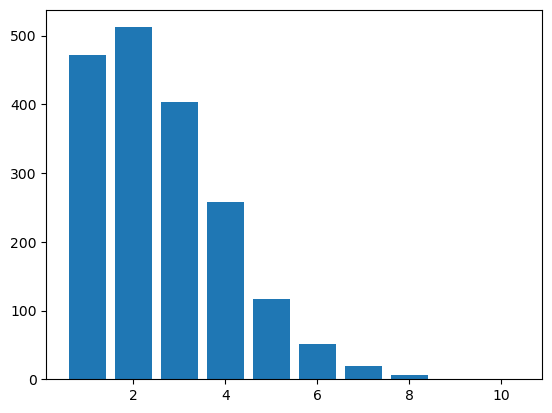

In [26]:
plt.bar(cnt_hc_1.keys(), cnt_hc_1.values())
plt.show()

In [27]:
cnt_hc_2= Counter(map(len, hash_conflicts_2.values()))
cnt_hc_2

Counter({21: 340,
         16: 210,
         22: 355,
         23: 331,
         24: 277,
         18: 306,
         20: 332,
         25: 232,
         19: 318,
         17: 235,
         27: 167,
         26: 205,
         11: 12,
         28: 132,
         30: 68,
         36: 7,
         15: 145,
         31: 55,
         13: 51,
         33: 14,
         35: 6,
         10: 13,
         14: 81,
         32: 45,
         29: 101,
         34: 13,
         12: 37,
         43: 1,
         37: 1,
         9: 6,
         39: 1,
         41: 1,
         8: 1})

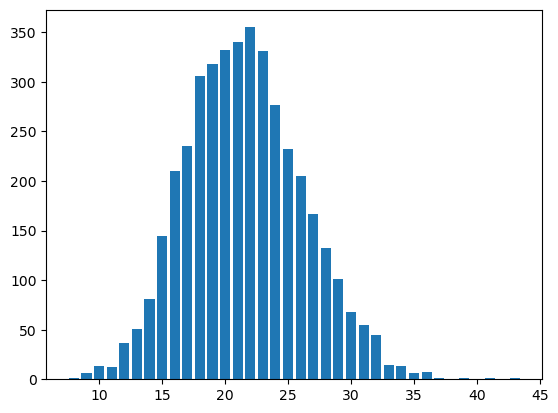

In [28]:
plt.bar(cnt_hc_2.keys(), cnt_hc_2.values())
plt.show()

In [29]:
cnt_hc_3 = Counter(map(len, hash_conflicts_3.values()))

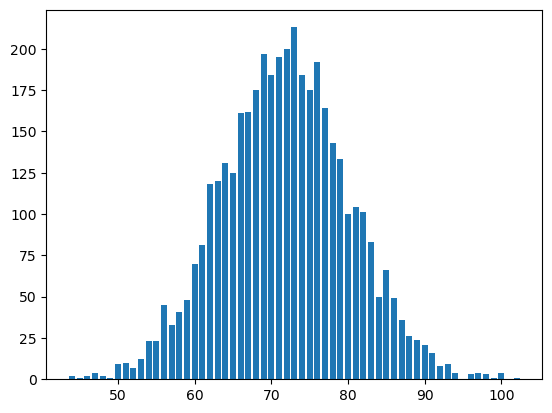

In [30]:
plt.bar(cnt_hc_3.keys(), cnt_hc_3.values())
plt.show()

## Multihot encoding

In [31]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

In [32]:
list(map(lambda x: hash(x) % MAX_TRIGRAMS, all_ngrams('banana')[2]))

[1395, 1992, 2010, 1992]

In [33]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

In [34]:
def hash_ngrams(ngrams, modulos):
    hash_codes = []
    for ngram_l, modulo in zip(ngrams, modulos):
        hash_codes += [list(map(lambda x: hash(x) % modulo, ngram_l))]
    return hash_codes

In [35]:
hash_banana = hash_ngrams(all_ngrams('banana'), MAXES)
hash_banana

[[1202, 1196, 315, 1196, 315, 1196],
 [3269, 1232, 1022, 1232, 1022],
 [1395, 1992, 2010, 1992]]

## Relative Frequencies
CLD3 associates the n-grams with their relative frequencies in the text

In [36]:
def rel_freqs(lst):
    return {ngram: lst.count(ngram)/len(lst) 
           for ngram in set(lst)}

In [37]:
list(map(rel_freqs, hash_banana))

[{1202: 0.16666666666666666, 315: 0.3333333333333333, 1196: 0.5},
 {1232: 0.4, 3269: 0.2, 1022: 0.4},
 {1992: 0.5, 2010: 0.25, 1395: 0.25}]

## Multihot vectors

In [38]:
def multihot(idxes, max):
    feat_vector = torch.zeros(max)
    for idx in idxes:
        feat_vector[idx] = 1.0
    return feat_vector

In [39]:
mhot_char_banana = multihot(hash_banana[0], MAX_CHARS)
mhot_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [40]:
for i in range(mhot_char_banana.size()[0]):
    if mhot_char_banana[i] == 1.0:
        print(i)

315
1196
1202


In [41]:
torch.nonzero(mhot_char_banana)

tensor([[ 315],
        [1196],
        [1202]])

In [42]:
multihot(hash_banana[1], MAX_BIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [43]:
multihot(hash_banana[2], MAX_TRIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

## Replacing Booleans with Frequencies

In [44]:
def freq_vectorizer(idx_freq, max):
    feat_vector = torch.zeros(max)
    for idx, freq in idx_freq.items():
        feat_vector[idx] = freq
    return feat_vector

In [45]:
freqs_banana = list(map(rel_freqs, hash_banana))
freqs_banana

[{1202: 0.16666666666666666, 315: 0.3333333333333333, 1196: 0.5},
 {1232: 0.4, 3269: 0.2, 1022: 0.4},
 {1992: 0.5, 2010: 0.25, 1395: 0.25}]

In [46]:
freq_char_banana = freq_vectorizer(freqs_banana[0], MAX_CHARS)
freq_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [47]:
for i in range(freq_char_banana.size()[0]):
    if freq_char_banana[i]:
        print(i, freq_char_banana[i])

315 tensor(0.3333)
1196 tensor(0.5000)
1202 tensor(0.1667)


In [48]:
torch.nonzero(freq_char_banana).T

tensor([[ 315, 1196, 1202]])

In [49]:
freq_char_banana[torch.nonzero(freq_char_banana)].T

tensor([[0.3333, 0.5000, 0.1667]])